## Example: Single Index Models and Minimum Variance Portfolio Allocation
The direct computation of the expected returns $\mathbb{E}(r_{i})$ of the covariance matrix $\Sigma$ in the _data-driven_ Minimum-Variance (Markowitz) portfolio problem can be computationally challenging as the number of assets in the portfolio grows. An alternative is to use index models to compute the expected returns and the covariance.

### Single index models (SIMs)
A single index model describes the return of a firm’s stock (or the return of an ETF) in terms of a firm-specific return and the overall market return. One of the simplest (yet still widely used) single index models was developed by [Sharpe (1963)](https://en.wikipedia.org/wiki/Single-index_model#:~:text=The%20single%2Dindex%20model%20(SIM,used%20in%20the%20finance%20industry.)). Let $R_{i}(t)\equiv\left(r_{i}\left(t\right) - r_{f}\right)$ 
and $R_{m}(t)\equiv\left(r_{m}\left(t\right)-r_{f}\right)$ denote the firm-specific and market **excess returns**, where $r_{f}$ denotes the risk-free rate of return.
Further, let $\epsilon_{i}\left(t\right)$ denote stationary normally distributed random noise
with mean zero and standard deviation $\sigma_{i}$. Then, the single index model of Sharpe is given by:
$$
\begin{equation*}
R_{i}\left(t\right) = \alpha_{i}+\beta_{i}\cdot{R}_{m}\left(t\right)+\epsilon_{i}
\left(t\right)\qquad{t=1,2,\dots,T}
\end{equation*}
$$
where $\alpha_{i}$ and $\beta_{i}$ are (unknown) model parameters: 
* $\alpha_{i}$ describes the firm-specific return not explained by the market; thus, $\alpha_{i}$ is the idiosyncratic return of firm $i$.
* $\beta_{i}$ has two interpretations. First, it measures the relationship between the excess return of firm $i$ and the excess return of the market. 
A large $\beta_{i}$ suggests that the market returns (or losses) are amplified for firm $i$, while a small $\beta_{i}$ indicates that the market returns (or losses) are damped for firm $i$. 
Second, it represents the relative risk of investing in a firm $i$ relative to the overall market.

### Single index model portfolio allocation problem for risky assets
The risky portfolio allocation problem for a portfolio $\mathcal{P}$ using the single index model is:
\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}\omega_{i}\omega_{j}
\text{cov}\left(R_{i},R_{j}\right) \\
\text{subject to}~\mathbb{E}(r_{\mathcal{P}})& = & \alpha_{\mathcal{P}}+\beta_{\mathcal{P}}\cdot\mathbb{E}(R_{m})\geq{R^{*}} \\
\alpha_{\mathcal{P}} & = & \sum_{i\in\mathcal{P}}\omega_{i}\cdot\alpha_{i}\\
\beta_{\mathcal{P}} & = & \sum_{i\in\mathcal{P}}\omega_{i}\cdot\beta_{i} \\
\sum_{i\in\mathcal{P}}\omega_{i} & = & 1 \\
\text{and}~\omega_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}

where the covariance between asset $i$ and asset $j$ is given by:
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}

### Learning objectives
The objective of this `worked example` is to compute the expected return vector $\mathbb{E}(R_{i})$ and the covariance matrix $\mathbf{\Sigma}$ using the `single index models` estimated in `CHEME-135 module 3`, where we use `SPY` as the market, or benchmark, portfolio. 

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-01-2023`.
* __Task 1__: Next, we'll compute the expected returns and the covariance arrays from the historical dataset using the single index models we computed in `CHEME-135 module 3`.
* __Task 2__: We'll compute the efficient frontier by solving the minimum variance optimization problem for the data-driven and the single index model formulation and compare the efficient frontiers calculated for each approach.
* __Task 3__: Finally, we'll compute the capital allocation line and the tangent portfolio using the single index models and look at some possible choices for the operating point to choose along the capital allocation line based upon your risk-aversion parameter $A$.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-4/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-4`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-4/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `11-03-2023`, along with data for a few exchange traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `load(...)` method exported by the [JLD2.jl](https://github.com/JuliaIO/JLD2.jl.git) package:

In [2]:
original_dataset = load(joinpath(_PATH_TO_DATA, "SP500-Daily-OHLC-1-3-2018-to-12-01-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of tradition days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 459 entries:
  "NI"   => 1489×8 DataFrame…
  "EMR"  => 1489×8 DataFrame…
  "CTAS" => 1489×8 DataFrame…
  "HSIC" => 1489×8 DataFrame…
  "KIM"  => 1489×8 DataFrame…
  "PLD"  => 1489×8 DataFrame…
  "IEX"  => 1489×8 DataFrame…
  "BAC"  => 1489×8 DataFrame…
  "CBOE" => 1489×8 DataFrame…
  "EXR"  => 1489×8 DataFrame…
  "NCLH" => 1489×8 DataFrame…
  "CVS"  => 1489×8 DataFrame…
  "DRI"  => 1489×8 DataFrame…
  "DTE"  => 1489×8 DataFrame…
  "ZION" => 1489×8 DataFrame…
  "AVY"  => 1489×8 DataFrame…
  "EW"   => 1489×8 DataFrame…
  "EA"   => 1489×8 DataFrame…
  "NWSA" => 1489×8 DataFrame…
  "CAG"  => 1489×8 DataFrame…
  "GPC"  => 1489×8 DataFrame…
  "FCX"  => 1489×8 DataFrame…
  "GILD" => 1489×8 DataFrame…
  "UNP"  => 1489×8 DataFrame…
  "CDW"  => 1489×8 DataFrame…
  ⋮      => ⋮

Let's get a list of firms that we have in cleaned up `dataset`, and save it ib the `all_tickers` array

In [5]:
all_tickers = keys(dataset) |> collect |> sort;

Finally, let's set some constant values, e.g., a value for the `risk_free_rate`:

In [6]:
risk_free_rate = 0.05;

### Compute the covariance and expected yield for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 459` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [7]:
all_firms_excess_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = risk_free_rate)

1488×459 Matrix{Float64}:
  0.324988   1.87928      6.97769   …   5.75159     1.74882    2.00452
  2.13987   -0.668139     3.97037       3.95668    -0.761936   2.9259
  0.886321  -1.96617     -0.853754      2.84928    -0.405978   2.41921
  6.15162    1.46203     -1.92102       6.55558     5.0984     3.36373
 -3.52638    4.87131     -0.317677      1.76502     3.3169    -4.92013
 -0.37572   10.2317       2.75668   …  10.6817      2.19034    2.43203
  3.25669    9.91413      7.32109       5.80955     2.34702    3.10105
 -0.219697   1.23539     -1.56874       2.67067    -1.60483    1.057
  1.64849   -0.305863     1.90851       0.389849   -0.152035   2.79631
  0.1633     0.0879042   -0.533602     -0.210856   -0.555564  -1.14091
  2.96852   -1.0269       3.81638   …  -0.0978694   2.23925    0.942827
  0.863209  -0.736871     0.950174      0.232196    1.8414     1.43424
  1.05596    0.0469966    1.8355        2.40996     1.35743    1.7796
  ⋮                                 ⋱                 

Next, we estimate the expected excess return for each firm from the `all_firms_excess_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(R_{1}),\dotsc,\mathbb{E}(R_{N})$ in the variable $\mu$:

In [8]:
μ = mean(all_firms_excess_return_matrix, dims=1) |> vec;

Finally, we estimate the annualized `covariance_matrix` from the `all_firms_return_matrix` using the `cov(...)` function, exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [9]:
Σ = cov(all_firms_excess_return_matrix) |> x-> x*(1/252) # annualized, historical volatility

459×459 Matrix{Float64}:
 0.0658353  0.0410327  0.026627   …  0.0442416  0.033664   0.0363971
 0.0410327  0.286132   0.0569432     0.0698228  0.0989086  0.0385518
 0.026627   0.0569432  0.123765      0.0381641  0.0490262  0.0286975
 0.032669   0.0450441  0.0239449     0.0458643  0.0269238  0.0340676
 0.0200583  0.0206882  0.020108      0.0176806  0.0217282  0.0226963
 0.0320454  0.0229962  0.0179767  …  0.0302212  0.0201696  0.0303122
 0.0349862  0.0482028  0.0324348     0.0453206  0.0396788  0.0357536
 0.0396146  0.0366659  0.0258094     0.0535129  0.0249936  0.0390114
 0.0385203  0.0641688  0.0290802     0.0548065  0.0421332  0.033596
 0.0209664  0.0473608  0.0259402     0.0278532  0.0448235  0.0182054
 0.0288275  0.0478733  0.0300245  …  0.0377944  0.0366992  0.031111
 0.0486152  0.0653181  0.0349384     0.0651247  0.040823   0.0432507
 0.0170372  0.0189179  0.0190907     0.0174609  0.0191911  0.020893
 ⋮                                ⋱                        
 0.0226957  0.0551617

### Build single index model returns and covariance

In [10]:
sims = load(joinpath(_PATH_TO_DATA, "SIMs-SP500-01-03-18-to-12-01-23.jld2")) |> x->x["sim"]

Dict{String, MySingleIndexModel} with 459 entries:
  "NI"   => MySingleIndexModel(-0.0709014, 0.652585, 0.05, Normal{Float64}(μ=7.…
  "EMR"  => MySingleIndexModel(-0.0587296, 1.23319, 0.05, Normal{Float64}(μ=6.4…
  "CTAS" => MySingleIndexModel(0.117183, 1.1806, 0.05, Normal{Float64}(μ=-5.372…
  "HSIC" => MySingleIndexModel(-0.0922378, 0.912801, 0.05, Normal{Float64}(μ=-5…
  "KIM"  => MySingleIndexModel(-0.0837113, 1.28542, 0.05, Normal{Float64}(μ=-7.…
  "PLD"  => MySingleIndexModel(0.0128753, 1.02335, 0.05, Normal{Float64}(μ=8.53…
  "IEX"  => MySingleIndexModel(-0.0153656, 0.962861, 0.05, Normal{Float64}(μ=-5…
  "BAC"  => MySingleIndexModel(-0.0965471, 1.3254, 0.05, Normal{Float64}(μ=-1.3…
  "CBOE" => MySingleIndexModel(-0.00806882, 0.591552, 0.05, Normal{Float64}(μ=1…
  "EXR"  => MySingleIndexModel(-0.00384653, 0.720622, 0.05, Normal{Float64}(μ=1…
  "NCLH" => MySingleIndexModel(-0.351379, 2.32966, 0.05, Normal{Float64}(μ=1.38…
  "CVS"  => MySingleIndexModel(-0.0931302, 0.783931, 0.05,

Store the index of the market portfolio in the `index_SPY` variable, and then the expected return of the market portfolio $\mathbb{E}(R_{m})$ in the `R_SPY` vector:

In [11]:
sims["MSFT"]

MySingleIndexModel(0.153445076699876, 1.1368428144098897, 0.05, Normal{Float64}(μ=-9.132479718690804e-17, σ=2.421360226018629))

In [12]:
index_SPY = findfirst(x->x=="SPY", all_tickers);
R_SPY = μ[index_SPY];

Now, compute the expected return for each ticker in `dataset` using the `single index models` computed in `Lab 12b` using a `for` loop. For iteration of the loop:
* Get the `ticker` symbol from the `all_tickers` array, and pull out the corresponding `single index model` from the `sims` dictionary
* Next, pull out the $(\alpha, \beta)$ parameters from the `sim` model instance and compute the expected return $\mathbb{E}(R_{i})$. Store the expected return in the `μ_sim` array

In [13]:
μ_sim = Array{Float64,1}();
for i ∈ eachindex(all_tickers)
    
    myticker = all_tickers[i];
    sim = sims[myticker];
    
    αᵢ = sim.α
    βᵢ = sim.β
    Rᵢ = αᵢ+βᵢ*R_SPY
    
    push!(μ_sim,Rᵢ)
end

Next let's build the `single index model` version of the covariance array. Substituting the single index model for the excess return of asset $i$ and $j$ into the covariance expression (and simplifying) gives:

$$
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}
$$

where $\sigma_{m}^2$ denotes the variance of the excess return of the market,  and $\sigma_{\epsilon_{i}}^{2}$ denotes the variance of the firm-specific error model.

In [33]:
σₘ = std(all_firms_excess_return_matrix[:, index_SPY]);

We populate the single index covariance array using nested `for` loops:

In [30]:
Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
for i ∈ eachindex(all_tickers)
    outer_ticker = all_tickers[i];
    sim_outer = sims[outer_ticker];
    
    for j ∈ eachindex(all_tickers)
        
        inner_ticker = all_tickers[j];
        sim_inner = sims[inner_ticker];
        
        if (i == j)
            βᵢ = sim_outer.β
            ϵᵢ = sim_outer.ϵ
            σ_ϵᵢ = params(ϵᵢ)[2];
            Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
        else
            βᵢ = sim_outer.β
            βⱼ = sim_inner.β
            Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
        end
    end
end
Σ_sim  = Σ_tmp |> x-> x*(1/252)

459×459 Matrix{Float64}:
 0.0658106  0.0478897  0.0271151  …  0.0384921  0.0369436  0.0286211
 0.0478897  0.285993   0.0445337     0.0632192  0.060676   0.0470071
 0.0271151  0.0445337  0.123699      0.0357946  0.0343547  0.0266154
 0.0338488  0.0555932  0.0314768     0.0446838  0.0428863  0.033225
 0.0193481  0.0317773  0.0179922     0.0255414  0.0245139  0.0189915
 0.0227327  0.0373361  0.0211396  …  0.0300094  0.0288022  0.0223137
 0.0330521  0.0542847  0.0307359     0.0436321  0.0418769  0.032443
 0.0344141  0.0565216  0.0320024     0.04543    0.0436024  0.0337798
 0.0337718  0.0554667  0.0314052     0.0445821  0.0427887  0.0331494
 0.0225092  0.036969   0.0209318     0.0297143  0.028519   0.0220943
 0.0278136  0.0456809  0.0258645  …  0.0367167  0.0352396  0.027301
 0.040131   0.065911   0.0373187     0.0529769  0.0508457  0.0393913
 0.0169774  0.0278835  0.0157876     0.0224118  0.0215102  0.0166644
 ⋮                                ⋱                        
 0.0235472  0.0386738

In [32]:
index_AMD = findfirst(x->x=="INTC", all_tickers);
Σ_sim[index_AMD,index_AMD] |> x-> sqrt(x)

0.3116154402444385

## Task 1: Build the return array and covariance matrix for our tickers
Before we compute the efficient frontier, we must decide which stocks to include in the risky portfolio. One strategy is to pick stocks that have small or even negative covariance. Let's explore this idea. 

* Specify a collection of `ticker symbols`, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers` array. We'll  put the indexes of your tickers in the `my_list_of_firm_ids` array:

In [17]:
my_list_of_tickers = ["AAPL", "INTC", "MSFT", "MU", "AMD", "GS", "BAC", "WFC", "C", "F"];
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end

Now that you have selected the firms in your risky portfolio, we'll compute for you the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, we'll construct the $\hat{\mu}$ vector for the `data` and `single index model` versions of the problem:

In [18]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
μ̂_sim = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
    push!(μ̂_sim, μ_sim[firm_index])
end
# ---------------------------------------------------------------------- #

and then we'll compute the firm-specific covariance $\hat{\Sigma}$ matrix for the `data` version of the problem:

In [19]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

and then the `single index model` version of the problem:

In [20]:
# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂_sim = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂_sim[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

## Task 2: Compute the efficient frontier for your collection of stocks
Create an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, and store this in the `problem_risk` variable using the `build(...)` method. You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the `build(...)` method. 

Let's setup the bounds, and some other constants:

In [21]:
number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 40;

and the build an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, using the `build(...)` method. Save the `data` version of the problem in the `problem_risk` variable:

In [22]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

and the `single index model` version of the problem in the `problem_risk_sim` variable:

In [23]:
problem_risk_sim = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂_sim,
    μ = μ̂_sim,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, we create an array with the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable:

In [24]:
minimum_desired_reward_array = range(0.0, stop = 0.5 - risk_free_rate, length = number_of_points) |> collect;

Finally, we iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward
* We then pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `frontier` dictionary.

In [25]:
efficient_frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk.R = minimum_desired_reward_array[i];
    
    # compute -
    solution = solve(problem_risk)

    # check: did this converge?
    status_flag = solution["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution["objective_value"]);
        value = solution["reward"];
        efficient_frontier[key] = value;
    end
end
efficient_frontier

Dict{Float64, Float64} with 30 entries:
  0.214388 => 0.161538
  0.340062 => 0.288462
  0.211949 => 0.15
  0.206653 => 0.0940113
  0.208487 => 0.126923
  0.206653 => 0.0940113
  0.217456 => 0.173077
  0.230842 => 0.207692
  0.363245 => 0.3
  0.206653 => 0.0940113
  0.387429 => 0.311538
  0.248714 => 0.230769
  0.206653 => 0.0940114
  0.206653 => 0.0940113
  0.26252  => 0.242308
  0.206653 => 0.0940113
  0.297626 => 0.265385
  0.206813 => 0.103846
  0.318099 => 0.276923
  0.412437 => 0.323077
  0.207423 => 0.115385
  0.438129 => 0.334615
  0.206653 => 0.0940113
  0.221227 => 0.184615
  0.225703 => 0.196154
  ⋮        => ⋮

Let's now do this for the single index model case, where we store the results in the `efficient_frontier_sim` dictionary:

In [26]:
efficient_frontier_sim = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_sim.R = minimum_desired_reward_array[i];
    
    # compute -
    solution_sim = solve(problem_risk_sim)

    # check: did this converge?
    status_flag = solution_sim["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution_sim["objective_value"]);
        value = solution_sim["reward"];
        efficient_frontier_sim[key] = value;
    end
end
efficient_frontier_sim

Dict{Float64, Float64} with 30 entries:
  0.208422 => 0.0921477
  0.409566 => 0.323077
  0.216848 => 0.184615
  0.222111 => 0.207692
  0.208422 => 0.0921477
  0.208422 => 0.0921477
  0.208422 => 0.0921477
  0.269034 => 0.253846
  0.357561 => 0.3
  0.209606 => 0.126923
  0.219242 => 0.196154
  0.208952 => 0.115385
  0.214798 => 0.173077
  0.228155 => 0.219231
  0.288456 => 0.265385
  0.436728 => 0.334615
  0.208422 => 0.092322
  0.238334 => 0.230769
  0.208422 => 0.0921477
  0.33308  => 0.288462
  0.208422 => 0.0921477
  0.211682 => 0.15
  0.383124 => 0.311538
  0.213098 => 0.161538
  0.208557 => 0.103846
  ⋮        => ⋮

### Visualize the Efficient Frontiers for the data and single index model

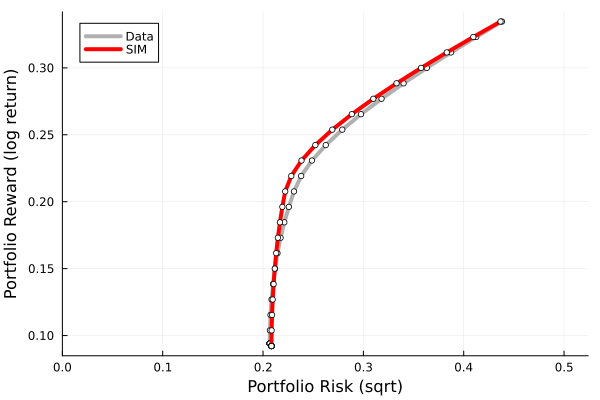

In [27]:
# regular -
plot(efficient_frontier, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Reward (log return)", fontsize=18, c=:gray69, 
    xlim=(0.0, 1.2*maximum(efficient_frontier).first), label="Data")
scatter!(efficient_frontier, label="", c=:white, mec=:black, ms=3)

# single index model -
plot!(efficient_frontier_sim, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Reward (log return)", fontsize=18, label="SIM", c=:red, 
    xlim=(0.0, 1.2*maximum(efficient_frontier_sim).first))
scatter!(efficient_frontier_sim, label="", c=:white, mec=:red, ms=3)

## Task 3: Compute the capital allocation line and the tangent portfolio using the single index models 
Let's create an instance of the `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` type and store this in the `problem_risk_free` variable using the `build(...)` method. We pass the covariance array estimated from data and the expected return value, along with bounds, an initial guess, and the risk-free rate to the `build(...)` method:

In [35]:
problem_risk_free = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = Σ̂_sim,
    μ = μ̂_sim,
    bounds = bounds,
    initial = wₒ,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level, in the presence of a risk-free asset, using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk_free` variable with the minimum desired reward
* We then pass the updated `problem_risk_free` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution_risk_free` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `capital_allocation_line` dictionary.

In [36]:
capital_allocation_line = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_free.R = minimum_desired_reward_array[i];
    
    # compute -
    solution_risk_free = solve(problem_risk_free)

    # check: did this converge?
    status_flag = solution_risk_free["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution_risk_free["objective_value"]);
        value = solution_risk_free["reward"];
        capital_allocation_line[key] = value;
    end
end
capital_allocation_line;

### Visualize the capital allocation line

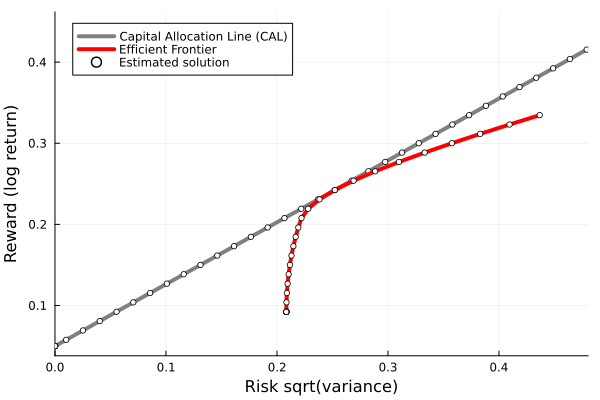

In [45]:
plot(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (annualized log growth)", fontsize=18, c=:gray, 
    xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
scatter!(capital_allocation_line, label="", msc=:black, mc=:white, ms=3)
plot!(efficient_frontier_sim, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (log return)", fontsize=18, label="Efficient Frontier", c=:red, 
    xlim=(0.0, 1.1*maximum(efficient_frontier_sim).first))
scatter!(efficient_frontier_sim, label="Estimated solution", c=:white, mec=:red, ms=3)

In [40]:
capital_allocation_line

Dict{Float64, Float64} with 40 entries:
  0.000127676 => 0.0500021
  0.146236    => 0.161538
  0.000151485 => 0.0499991
  0.11598     => 0.138462
  0.131108    => 0.15
  0.221875    => 0.219231
  0.000151502 => 0.0499993
  0.448792    => 0.392308
  0.479048    => 0.415385
  0.000127666 => 0.0500019
  0.000127483 => 0.0500016
  0.327769    => 0.3
  0.509303    => 0.438462
  0.388281    => 0.346154
  0.342897    => 0.311538
  0.312642    => 0.288462
  0.267258    => 0.253846
  0.100852    => 0.126923
  0.0857243   => 0.115385
  0.494176    => 0.426923
  0.373153    => 0.334615
  0.418536    => 0.369231
  0.0100862   => 0.0576924
  0.176491    => 0.184615
  0.297514    => 0.276923
  ⋮           => ⋮

### Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.